# Transfer Learning with MobileNetV2

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

# objectives of the kernel


- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

<a name='1'></a>
## 1 - Packages

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Load flowers dataset

In [29]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [30]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

<a name='1-1'></a>
### - Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap. :) 


In [31]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


**show some images:**

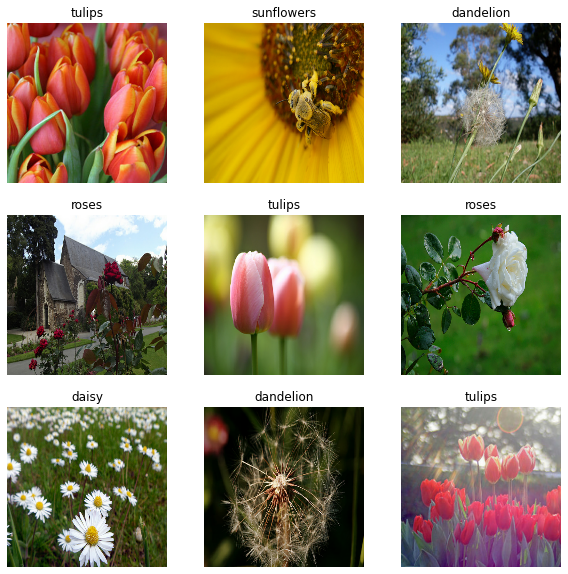

In [32]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

-Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk and you can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. 

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
###  - data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [34]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

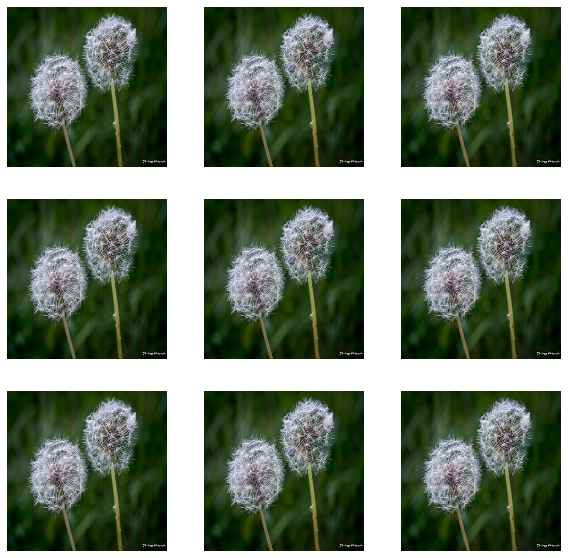

In [35]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers


<a name='3-1'></a>
###  - Inside a MobileNetV2 Convolutional Building Block


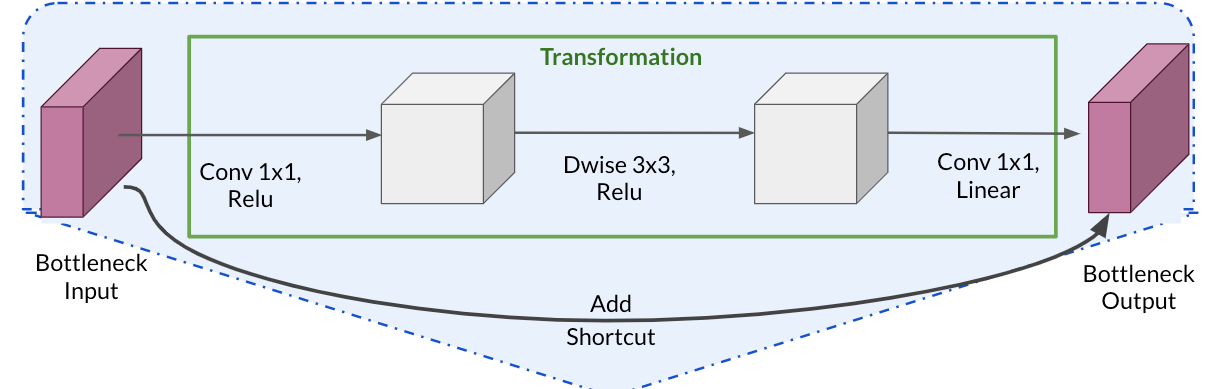
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br>  <a 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**


Let's try to train your base model using all the layers from the pretrained model. 

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`. 

In [37]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [38]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [39]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [40]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n11939491', 'daisy', 0.91963714),
  ('n07753275', 'pineapple', 0.0058137653)],
 [('n11939491', 'daisy', 0.20483771), ('n03991062', 'pot', 0.1446054)],
 [('n11939491', 'daisy', 0.8235087), ('n02206856', 'bee', 0.015604141)],
 [('n11939491', 'daisy', 0.99236894), ('n02219486', 'ant', 0.0014044186)],
 [('n11939491', 'daisy', 0.43836835), ('n03476684', 'hair_slide', 0.08645644)],
 [('n12057211', "yellow_lady's_slipper", 0.11395955),
  ('n02219486', 'ant', 0.0909544)],
 [('n11939491', 'daisy', 0.6123731), ('n07730033', 'cardoon', 0.057197344)],
 [('n02948072', 'candle', 0.16637231),
  ('n07768694', 'pomegranate', 0.10330326)],
 [('n11939491', 'daisy', 0.5877582), ('n03476684', 'hair_slide', 0.013195885)],
 [('n11939491', 'daisy', 0.26091856), ('n02206856', 'bee', 0.17732793)],
 [('n11939491', 'daisy', 0.12826118),
  ('n03457902', 'greenhouse', 0.051411465)],
 [('n11879895', 'rapeseed', 0.95308554),
  ('n03930313', 'picket_fence', 0.0038322795)],
 [('n02206856', 'bee', 0.14179108),
  ('n

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for flower , so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.

<a name='3-2'></a>
###  - Layer Freezing with the Functional API


1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

<a name='ex-2'></a>
### - flower_model

In [41]:
def flower_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with five neuron 
    prediction_layer = tfl.Dense(5)
    outputs = prediction_layer(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [42]:
model2 = flower_model(IMG_SIZE, data_augmentation)

The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [44]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
92/92 [==============================] - 55s 553ms/step - loss: 0.8892 - accuracy: 0.6666 - val_loss: 0.5844 - val_accuracy: 0.7820
Epoch 2/5
92/92 [==============================] - 59s 641ms/step - loss: 0.4828 - accuracy: 0.8253 - val_loss: 0.4531 - val_accuracy: 0.8324
Epoch 3/5
92/92 [==============================] - 55s 590ms/step - loss: 0.3838 - accuracy: 0.8587 - val_loss: 0.4485 - val_accuracy: 0.8392
Epoch 4/5
92/92 [==============================] - 53s 571ms/step - loss: 0.3483 - accuracy: 0.8689 - val_loss: 0.4283 - val_accuracy: 0.8420
Epoch 5/5
92/92 [==============================] - 53s 578ms/step - loss: 0.3320 - accuracy: 0.8774 - val_loss: 0.4067 - val_accuracy: 0.8447


Plot the training and validation accuracy:

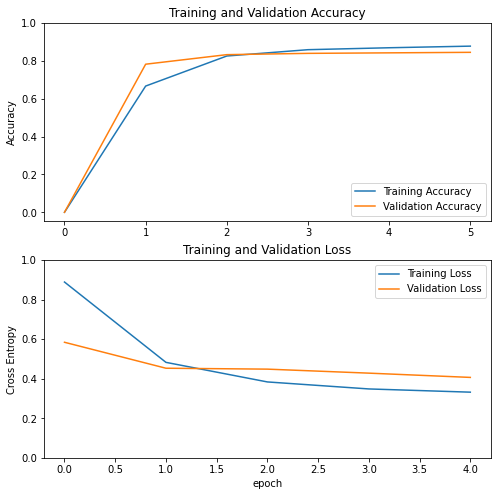

In [46]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

**The results are ok, but could be better. Next, try some fine-tuning.**

<a name='3-3'></a>
### - Fine-tuning the Model

In [59]:
base_model = model2.layers[4]

In [61]:
base_model.trainable = True

In [62]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [63]:
# Fine-tune from this layer onwards
fine_tune_at = 120
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)


In [64]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
92/92 [==============================] - 67s 685ms/step - loss: 0.4211 - accuracy: 0.8542 - val_loss: 0.3758 - val_accuracy: 0.8474
Epoch 6/10
92/92 [==============================] - 63s 686ms/step - loss: 0.3016 - accuracy: 0.8944 - val_loss: 0.3655 - val_accuracy: 0.8665
Epoch 7/10
92/92 [==============================] - 65s 706ms/step - loss: 0.2377 - accuracy: 0.9114 - val_loss: 0.3159 - val_accuracy: 0.8760
Epoch 8/10
92/92 [==============================] - 63s 689ms/step - loss: 0.1952 - accuracy: 0.9312 - val_loss: 0.3093 - val_accuracy: 0.8910
Epoch 9/10
92/92 [==============================] - 71s 766ms/step - loss: 0.1672 - accuracy: 0.9418 - val_loss: 0.3214 - val_accuracy: 0.8937
Epoch 10/10
92/92 [==============================] - 67s 723ms/step - loss: 0.1357 - accuracy: 0.9513 - val_loss: 0.2854 - val_accuracy: 0.9074


In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

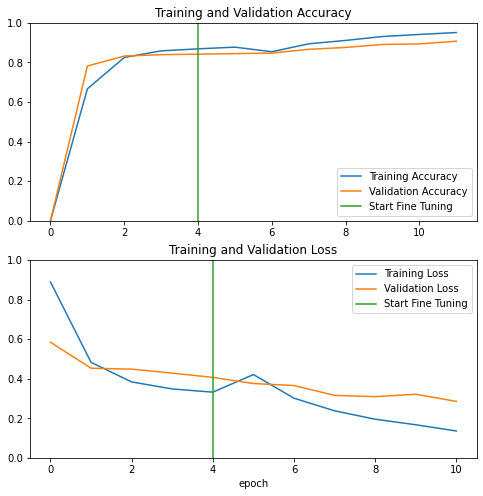

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Ahhh, quite an improvement! A little fine-tuning can really go a long way.**

<a name='6'></a>  
## - Bibliography

-[Convolutional Neural Networks androw ng ](https://www.coursera.org/learn/convolutional-neural-networks/programming/nZima/transfer-learning-with-mobilenet)

[MobileNetV2: The Next Generation of On-Device Computer Vision Networks](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.)

[Transfer Learning | Deep Learning Tutorial 27 (Tensorflow, Keras & Python)](https://www.youtube.com/watch?v=LsdxvjLWkIY&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=27)